# Fisher Information Matrix: Expected Hessian, Sensitivity and Robustness

In this notebook, we investigate the Fisher Information matrix (FIM) from various angles. We do this for both, the FIM of the stochastic model (informed by the van Kampen expansion of the chemical Master equation of the process) and the FIM of the deterministic model (ODE based, including a constant measurement error). First, we look at its properties as the expected Hessian and compare with the observed Hessian of our posterior distribution. We then look at two sensitivity measures computed from the FIM (as in [Sensitivity Analysis of Discrete Stochastic Systems](https://doi.org/10.1529/biophysj.104.053405)). Finally, we briefly analyse the expected robustness of the model to simultaneous changes in parameters. 

The model used for generating data and defining the observation process can be found in more detail in ex13_calibration_latent_SIR.

In [1]:
%matplotlib inline
import numpy as np
import pyross
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

## 1) Generate a trajectory
We generate a test trajectory on a population with four ages groups using UK contact matrix

In [2]:
np.random.seed(1)

## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
fi = Ni/N 

# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = CH0[i,:]*Ni0[i]
    CW0[i,:] = CW0[i,:]*Ni0[i]
    CS0[i,:] = CS0[i,:]*Ni0[i]
    CO0[i,:] = CO0[i,:]*Ni0[i]


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )/Ni[i]
        
print(N)

64111602.0


In [3]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

# Set intervention time, and the total length for the trajectory 
T_intervention = 100 # intervention time 
Tf = 600
Nf = Tf+1

# a tanh function for intervention 
def approx_tanh(t, width, loc):
    cond1 = (t < loc-width/2)
    cond2 = (t >= loc+width/2)
    cond3 = np.logical_and((t < loc+width/2), (t >= loc-width/2))
    cond_list = [cond1, cond2, cond3]
    fun_list = [-1, 1, lambda t: 2*(t-loc)/width]
    return np.piecewise(t, cond_list, fun_list)
    
def intervention_fun(t, M, width=1, loc=0, aW_f=0, aS_f=0, aO_f=0):
    aW = (1-approx_tanh(t, width, loc))/2*(1-aW_f) + aW_f
    aS = (1-approx_tanh(t, width, loc))/2*(1-aS_f) + aS_f
    aO = (1-approx_tanh(t, width, loc))/2*(1-aO_f) + aO_f
    aW_full = np.full((2, M), aW) # must return the full (2, M) array 
    aS_full = np.full((2, M), aS)
    aO_full = np.full((2, M), aO)
    return aW_full, aS_full, aO_full

In [4]:
beta  = 0.02      # contact rate parameter
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
alpha = 0.2              # asymptomatic fraction
fsa   = 1               # suppresion of contact by symptomatics


# initial conditions    
Is0 = np.zeros(M)
Is0[1] = 10 
Ia0 = np.zeros((M))
R0  = np.zeros((M))
S0  = Ni - (Ia0 + Is0 + R0)

# contact matrix 
width = 10 
loc = T_intervention 
aW_f = 0.9
aS_f = 0.8 
aO_f = 0.8 
contactMatrix = generator.intervention_custom_temporal(intervention_fun, 
                                                       width=width, loc=loc, 
                                                       aW_f=aW_f, aS_f=aS_f, aO_f=aO_f)

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa,
             'seed':1}
model = pyross.stochastic.SIR(parameters, M, Ni)

# start simulation
Tf=600;  Nf=Tf+1 
data=model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf, method='tau-leaping')
np.save('cal_lat_SIR_traj.npy', data['X'])

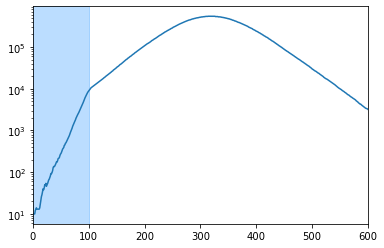

In [5]:
# plot the number of infected people 
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
plt.semilogy(t, IC)
plt.axvspan(0, T_intervention, 
           label='Pre intervention',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.show() 

## 2) Infer the parameters and initial conditions for the pre-intervention trajectory

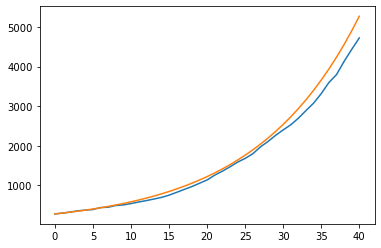

In [6]:
N_start = 50 
Tf_initial = 40 # truncate to only getting the pre-intervention trajectory 
Nf_initial = Tf_initial+1

x = (np.load('cal_lat_SIR_traj.npy')).astype('float')
x = x[N_start:N_start+Nf_initial]

# a filter that yields the Is only 
fltr = np.kron([0, 0, 1],np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x)
x0 = x[0] 

steps = 4 # number of steps 
estimator = pyross.inference.SIR(parameters, M, Ni, 1, steps,
                                rtol_det=1e-8)

# Check the deterministic simulation against stochstic simulations with the same parameters and initial conditions 
# They are likely to be different due to the inherent stochasticity of the model 

estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)
xm = estimator.integrate(x0, 0, Tf_initial, Nf_initial)
t = np.linspace(0, Tf_initial, Nf_initial)
plt.plot(t, np.sum(x[:,2*M:3*M], axis=1))
plt.plot(t, np.sum(xm[:,2*M:3*M], axis=1))
plt.show()

In [7]:
# Compute -log_p for the original (correct) parameters 
# This gives an estimate of the final -logp we expect from the optimisation scheme 
start_time = time.time() 
parameters = {'alpha': alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x0, obs, fltr, Tf_initial, contactMatrix, tangent=True)
end_time = time.time()
print(logp) 
print(end_time - start_time)

588.5363474838662
0.045289039611816406


In [8]:
# make parameter guesses and set up bounds for each parameter 

eps=1e-4
param_priors = {
    'alpha':{
        'mean': 0.2, 
        'std': 0.05, 
        'bounds': [eps, 0.5]
    },
    'beta':{
        'mean': 0.04, 
        'std': 0.1,
        'bounds': [eps, 0.4]
    }, 
    'gIa':{
        'mean': 0.13, 
        'std': 0.05, 
        'bounds': [eps, 0.3]
    }, 
    'gIs':{
        'mean': 0.14, 
        'std': 0.05, 
        'bounds': [eps, 0.3]
    }
}

Ia0_g = x0[M:2*M]
Ia_std = Ia0_g*2
bounds_for_Ia = np.tile([0.1, N], M).reshape(M, 2)

S0_g = x0[:M]
S_std = Ia_std*2
bounds_for_S = np.tile([0.1, N], M).reshape(M, 2)

init_fltr = np.repeat([True, True, False], M)

init_priors = {
    'independent':{
        'fltr': init_fltr, 
        'mean': [*S0_g, *Ia0_g], 
        'std': [*S_std, *Ia_std], 
        'bounds': [*bounds_for_S, *bounds_for_Ia]
    }
}


# Optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  


start_time = time.time()

#old function call: deprecated but still working (as a wrapper of latent_infer)
#res = estimator.latent_infer_parameters(obs, fltr, Tf_initial, contactMatrix, param_priors, init_priors, 
#                                        tangent=True, global_max_iter=30, global_atol=1, verbose=True, ftol=ftol, cma_random_seed=2873392800) 
res = estimator.latent_infer(obs, fltr, Tf_initial, param_priors, init_priors, contactMatrix=contactMatrix,
                                        tangent=True, global_max_iter=300, global_atol=1, verbose=True, ftol=ftol, cma_random_seed=2873392800,
                            local_max_iter=10000)

end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 12 (seed=2873392800, Thu Aug  6 20:58:00 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 9.322367705930518e+02 1.0e+00 1.01e+00  5e-02  9e+01 0:00.7
    2     32 6.174948895008233e+02 1.3e+00 1.01e+00  5e-02  9e+01 0:01.5
    3     48 7.613690737106995e+02 1.3e+00 1.04e+00  5e-02  9e+01 0:02.3
    7    112 6.573339899022891e+02 1.5e+00 8.90e-01  4e-02  8e+01 0:05.8
   12    192 6.901501906269677e+02 2.0e+00 8.75e-01  4e-02  8e+01 0:09.8
   19    304 6.535391433214072e+02 2.4e+00 1.03e+00  5e-02  1e+02 0:15.4
   27    432 7.285647454239637e+02 3.0e+00 1.13e+00  5e-02  1e+02 0:22.0
   36    576 8.400967175492864e+02 3.9e+00 1.29e+00  6e-02  1e+02 0:29.4
   46    736 7.623879133095506e+02 5.4e+00 1.37e+00  4e-02  1e+02 0:37.8
   58    928 5.374821173303553e+03 7.1e+00 1.63e+00  5e-02  2e+02 0:47.6
   71   1136 7.606623447320292e+02 8.6e+00 9.57e-01  2e-02  8e+01 0:57

In [9]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
print(parameters)

best_estimates = res['params_dict']
print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print(x0.astype('int'))


map_x0 = res['x0']
print('\n Inferred initial conditions: ') 
print(map_x0.astype('int'))

True parameters
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 1}

 Best estimates
{'alpha': 0.1571640273926629, 'beta': 0.01976756552828711, 'gIa': 0.14589325993478594, 'gIs': 0.13900299527090698, 'fsa': array([1., 1., 1., 1.])}

 True initial conditions: 
[15634069 17833838 17762783 12879838       23       16       15        5
      104       88       71       17]

 Inferred initial conditions: 
[15634074 17833829 17762789 12879839        2        1        1        0
      104       88       71       17]


In [10]:
logp = estimator.minus_logp_red(best_estimates, map_x0, obs, fltr, Tf_initial, contactMatrix, tangent=True)
print(logp)

588.7923750127412


## Compute the observed Hessian and the Laplacian model evidence approximation 

In [11]:
hessian = estimator.latent_hessian(obs, fltr, Tf_initial,
        res, contactMatrix=contactMatrix, tangent=True,
        eps=None, inter_steps=100)

# Check that Hessian is positive definite - if not, change eps
# and/or inter_steps
print(np.all(np.linalg.eigvalsh(hessian) > 0))

epsilon used for differentiation:  [0.00072583 0.00043158 0.00072583 0.00072583 0.06569503 0.078125
 0.078125   0.06569503 0.00145167 0.0012207  0.0012207  0.00086317]
True


In [12]:
evidence_approx = estimator.latent_evidence_laplace(obs, fltr, Tf_initial,
        res, contactMatrix=contactMatrix, tangent=True,
        eps=None, inter_steps=100)

print('log-Posterior at MAPs: ', res['log_posterior'])
print('Approximate model evidence: ', evidence_approx)

epsilon used for differentiation:  [0.00072583 0.00043158 0.00072583 0.00072583 0.06569503 0.078125
 0.078125   0.06569503 0.00145167 0.0012207  0.0012207  0.00086317]
log-Posterior at MAPs:  -608.1214241287129
Approximate model evidence:  -598.1990941680712


## Compute FIM 

The FIM $\mathcal{I}(\theta)$ is the expected Hessian matrix, assuming flat priors and maximum information gain from the data. Thus, the covariances obtained from the FIM via 

$$
C = \mathcal{I}^{-1},
$$

with $C$ being the expected covariance matrix, can be interpreted as a lower bound on the variance of an unbiased estimator, see Cramér-Rao bound. Compare the expected with the observed covariances obtained by the FIM and the Hessian, respectively. 

Achieving a lower covariance than the expected one clearly indicates that the chosen priors are effective at incorporating prior knowledge.

In [13]:
FIM = estimator.latent_FIM(obs=obs, fltr=fltr, Tf=Tf_initial,
        infer_result=res, contactMatrix=contactMatrix,
                          tangent=True, eps=None, inter_steps=100)

# Check that FIM is positive definite - if not, change eps
# and/or inter_steps
print(np.all(np.linalg.eigvalsh(FIM) > 0))

eps-vector used for differentiation:  [3.02772723e-05 1.51386361e-05 3.02772723e-05 3.02772723e-05
 1.23039165e-02 1.55019634e-02 1.55019634e-02 1.23039165e-02
 7.62939453e-05 6.05545445e-05 6.05545445e-05 3.81469727e-05]
True


In [14]:
print('Parameter standard deviations are:\n')
if np.all(np.linalg.eigvalsh(hessian) > 0):
    print(np.sqrt(np.diagonal(np.linalg.inv(hessian))))
else:
    print('Hessian not positive definite - check eps and inter_steps used!')
    
print('\n\nExpected standard deviations are:\n')
if np.all(np.linalg.eigvalsh(FIM) > 0):
    print(np.sqrt(np.diagonal(np.linalg.inv(FIM))))
else:
    print('FIM not positive definite - check eps and inter_steps used!')
    

Parameter standard deviations are:

[3.44926261e-02 1.42867485e-03 4.41822449e-02 1.79688472e-02
 9.19999889e+01 6.39997772e+01 5.99997497e+01 1.99997921e+01
 3.64068682e+00 2.46171873e+00 2.08053831e+00 6.04672081e-01]


Expected standard deviations are:

[7.08214662e-01 6.11876075e-02 3.91838757e-01 2.59752588e-02
 5.12015564e+07 5.83806452e+07 5.81423272e+07 4.21573630e+07
 8.56782810e+01 1.13036058e+02 1.29892325e+02 9.81645561e+01]


## Sensitivity analysis

First order sensitivity measure: $S_{ij}=\frac{\partial \mu_i}{\partial \theta_j}$

Square-root of the diagonals of the FIM $\mathcal{I}(\theta)$ can be interpreted as sensitivity to changes in individual parameters.

Inverse of the square-root of diagonal elements of the 'expected covariance matrix' ($C=\mathcal{I}^{-1}(\theta)$) represents the sensitivity to correlated changes in parameters. 
______________________

In addition to the above FIM of the stochastic model, compute the FIM of an ODE based deterministic model with a constant measurement error: 

Stochastic FIM for a multivariate normal distribution $X\sim \mathcal{N}(\mu(\theta),\Sigma(\theta))$:

$$
\mathcal{I}_{ij}=\frac{\partial\mu^T}{\partial\theta_i}\Sigma^{-1}
\frac{\partial\mu}{\partial\theta_j} + \frac{1}{2} \text{tr}\left(\Sigma^{-1}
\frac{\partial\Sigma}{\partial\theta_i}\Sigma^{-1}
\frac{\partial\Sigma}{\partial\theta_j}\right)
$$

If $\Sigma(\theta)=\Sigma$, a constant, can interpret this as a diagonal matrix of measurement errors $\sigma^2_m$ for the deterministic mean evolution. Thus, for the 'deterministic' model 

$$
\mathcal{I}_{ij}=\frac{\partial\mu^T}{\partial\theta_i}\Sigma^{-1}
\frac{\partial\mu}{\partial\theta_j}
$$

________________________

Compute sensitivity measures for both, individual parameter changes and incorporating parametric interactions (named 'individual' and 'correlated', respectively) for the stochastic and the deterministic FIM and compare. A larger entry translates into greater anticipated model sensitivity to changes in the parameter of interest. If sensitivity to a certain parameter is low for the deterministic model, but high for the stochastic model, this parameter is expected to have  a substantial effect on the stochasticity of the process

In [15]:
FIM_det = estimator.latent_FIM_det(obs, fltr, Tf_initial,
        infer_result=res, contactMatrix=contactMatrix, eps=None,
        measurement_error=1e-2, inter_steps=100)

# Check that FIM_det is positive definite - if not, change eps
# and/or inter_steps
print(np.all(np.linalg.eigvalsh(FIM_det) > 0))

eps-vector used for differentiation:  [3.02772723e-05 1.51386361e-05 3.02772723e-05 3.02772723e-05
 1.23039165e-02 1.55019634e-02 1.55019634e-02 1.23039165e-02
 7.62939453e-05 6.05545445e-05 6.05545445e-05 3.81469727e-05]
True


In [16]:
# multiply by MAP estimates to standardise sensitivities
individual_sto, correlated_sto = estimator.sensitivity(FIM)*res['flat_params']
individual_det, correlated_det = estimator.sensitivity(FIM_det)*res['flat_params']

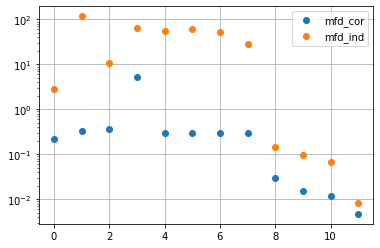

In [17]:
No = np.arange(0, len(res['flat_params']))

# Compare correlated and individual sensitivities for manifold
plt.semilogy(No, correlated_sto, 'o', label='mfd_cor')
plt.semilogy(No, individual_sto, 'o', label='mfd_ind')
plt.grid()
plt.legend()
plt.show()

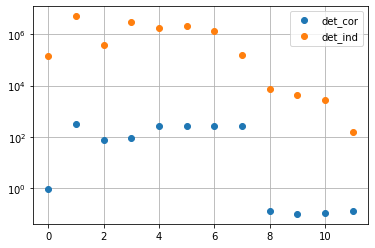

In [18]:
# Compare correlated and individual sensitivities for deterministic
plt.semilogy(No, correlated_det, 'o', label='det_cor')
plt.semilogy(No, individual_det, 'o', label='det_ind')
plt.grid()
plt.legend()
plt.show()

In [19]:
# Normalise sensitivities to compare the stochastic
# and the deterministic model

ind_sto_norm = individual_sto/np.sum(individual_sto)
cor_sto_norm = correlated_sto/np.sum(correlated_sto)

ind_det_norm = individual_det/np.sum(individual_det)
cor_det_norm = correlated_det/np.sum(correlated_det)

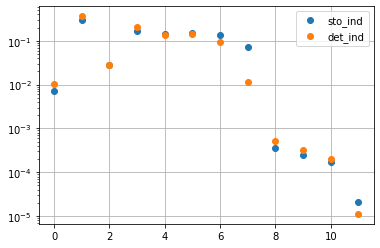

In [20]:
# Compare individual sensitivities for deterministic and stochastic
plt.semilogy(No, ind_sto_norm, 'o', label='sto_ind')
plt.semilogy(No, ind_det_norm, 'o', label='det_ind')
plt.grid()
plt.legend()
plt.show()

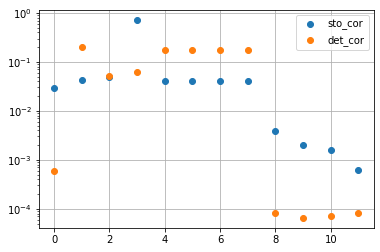

In [21]:
# Compare correlated sensitivities for deterministic and stochastic
plt.semilogy(No, cor_sto_norm, 'o', label='sto_cor')
plt.semilogy(No, cor_det_norm, 'o', label='det_cor')
plt.grid()
plt.legend()
plt.show()

## Robustness analysis

Compare the expected correlations of the deterministic and the stochastic model. This can serve as a measure of how robust the model is around the MAP estimates to simultaneous changes in parameters. Regions within such covariance ellipses are called neutral spaces.

In [22]:
ff, ss, Z_sto, Z_det = estimator.robustness(FIM=FIM, FIM_det=FIM_det,
                infer_result=res, param_pos_1=0,
                param_pos_2=1, range_1=0.5,
                range_2=0.01, resolution_1=int(20))

Plot the expected correlations of the inferred $\alpha$ and $\beta$. The heat map represents the stochastic model, the thick dashed contour lines are generated by the deterministic model. Clearly, stochasticity induces extra correlations.

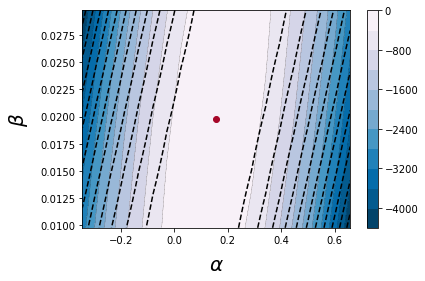

In [23]:
cmap = plt.cm.PuBu_r
levels=11
colors='black'

c = plt.contourf(ff, ss, Z_sto, cmap=cmap, levels=levels)
plt.contour(ff, ss, Z_sto, colors='black', levels=levels, linewidths=0.25)
plt.contour(ff, ss, Z_det, colors=colors, levels=levels)
plt.plot(res['flat_params'][0], res['flat_params'][1], 'o',
            color="#A60628", markersize=6)
plt.colorbar(c)
plt.xlabel(r'$\alpha$', fontsize=20, labelpad=10)
plt.ylabel(r'$\beta$', fontsize=20, labelpad=10)
plt.show()